In [0]:
import numpy as np
import torch
import pickle
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import time
import torch.optim as optim

import matplotlib.pyplot  as plt
import matplotlib.animation as animation
%matplotlib inline

from IPython.display import HTML

# Generativ Adversarial Networks
In this problem, you will investigate different topics related to GAN’s.
## (a) Part A
Model Design
- Design a DCGAN of your own choice for the colored MNIST. you can get help
from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
You can access the colored MNIST using the information from the previous
exercise. You can find helpful hints for training from https://medium.com/@jonathan_hui/gan-gan-series-2d279f906e7b
Deliverables
- summerize your configuration and techniques used for training
- Having your model trained, generate 32 examples from the generator. Summerize
frequency of each digit generated by the generator in a table.

In [0]:
batch_size = 100

# cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number Gpus
ngpu = 1

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 16

# Size of feature maps in discriminator
ndf = 16

# Number of training epochs
EPOCHS = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
with open('drive/My Drive/Colab Notebooks/colored-mnist.pkl', 'rb') as f:
  data = pickle.load(f)

In [5]:
train = data['train']
test = data['test']

print("Count train samples: ", train.shape[0])
print("Count test samples: ", test.shape[0])
print("Shape of image (H, W, C): ", train[0].shape)

Count train samples:  60000
Count test samples:  10000
Shape of image (H, W, C):  (28, 28, 3)


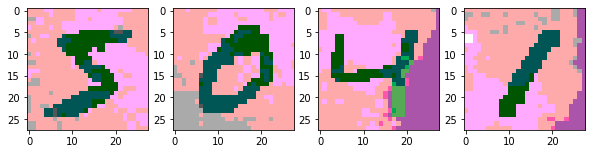

In [6]:
fig = plt.figure(figsize=(10, 10))
def show_image(i, image): 
  print_image =  image * (255 / 3)
  fig.add_subplot(1, 4, i+1)
  plt.imshow(print_image.astype(int))
  

for i in range(0, 4):
  show_image(i, train[i])
plt.show()

In [0]:
from skimage.transform import resize
data = []
for i in train:
  im = resize(i, (64,64,3))
  data.append(im * (255 / 3))

for i in test:
  im = resize(i, (64,64,3))
  data.append(im * (255 / 3))

In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, target, transform=None):
    self.target =  torch.from_numpy(target).permute(0, 3, 1, 2).float()
    self.transform = transform
      
  def __getitem__(self, index):
    x = self.target[index]
    
    if self.transform:
        x = self.transform(x)
        
    return x
  
  def __len__(self):
    return len(self.target)

In [0]:
train_ds = MyDataset(np.array(data))

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)

In [0]:
dataiter = iter(trainloader)
image = dataiter.next()
print("Tensor shape: ", image.shape)

fig = plt.figure(figsize=(10, 10))
for i in range(4):
  print_image =  image[i].permute(1,2,0).numpy() 

  print_image =  print_image
  fig.add_subplot(1, 4, i+1)
  plt.imshow(print_image, cmap='gray')

plt.show()

### Define the GAN
I used the model from the pytorch Tutorial
(https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [0]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # state size. (nc) x 64 x 64
    )

  def forward(self, input):
    out = self.main(input)
    # print("Ge out:", out.shape)
    return out

In [13]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [0]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # input is (nc) x 64 x 64
      nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf) x 32 x 32
      nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 2),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*2) x 16 x 16
      nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*4) x 8 x 8
      nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 8),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*8) x 4 x 4
      nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    out = self.main(input)
    # print("De out:", out.shape)
    return out

In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
def train_d_net_with_real(data, label):
  '''
  Update D network: maximize log(D(x)) + log(1 - D(G(z)))
  '''
  ## Train with all-real batch
  netD.zero_grad()
  # Format batch
  real_cpu = data.to(device)

  # Forward pass real batch through D
  output = netD(real_cpu).view(-1)
  # print("real_out:", output.shape)
  # Calculate loss on all-real batch
  errD_real = criterion(output, label)
  # Calculate gradients for D in backward pass
  errD_real.backward()
  D_x = output.mean().item()
  return errD_real, D_x

In [0]:
def train_d_net_with_fake(label, fake, errD_real):
  '''
  Train with all-fake batch
  '''
  
  label.fill_(fake_label)
  # Classify all fake batch with D
  output = netD(fake.detach()).view(-1)
  # Calculate D's loss on the all-fake batch
  errD_fake = criterion(output, label)
  # Calculate the gradients for this batch
  errD_fake.backward()
  D_G_z1 = output.mean().item()
  # Add the gradients from the all-real and all-fake batches
  errD = errD_real + errD_fake
  # Update D
  optimizerD.step()
  return errD, D_G_z1

In [0]:
def train_g_net(data, label, fake):
  '''
  Update G network: maximize log(D(G(z)))
  '''
  netG.zero_grad()
  label.fill_(real_label)  # fake labels are real for generator cost
  # Since we just updated D, perform another forward pass of all-fake batch through D
  output = netD(fake).view(-1)
  # Calculate G's loss based on this output
  errG = criterion(output, label)
  # Calculate gradients for G
  errG.backward()
  D_G_z2 = output.mean().item()
  # Update G
  optimizerG.step()

  return errG, D_G_z2

[0/5][0/700]	Loss_D: 1.6373	Loss_G: 1.1606	D(x): 0.3544	D(G(z)): 0.4180 / 0.3307


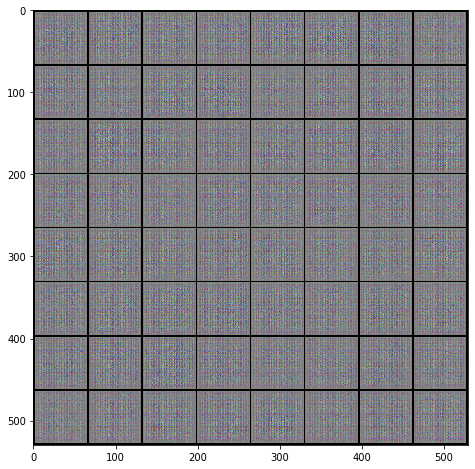

[0/5][50/700]	Loss_D: 0.0687	Loss_G: 4.5878	D(x): 0.9833	D(G(z)): 0.0501 / 0.0115
[0/5][100/700]	Loss_D: 0.0193	Loss_G: 5.5177	D(x): 0.9938	D(G(z)): 0.0129 / 0.0043
[0/5][150/700]	Loss_D: 0.0081	Loss_G: 6.3536	D(x): 0.9965	D(G(z)): 0.0046 / 0.0018
[0/5][200/700]	Loss_D: 0.0148	Loss_G: 6.9500	D(x): 0.9984	D(G(z)): 0.0131 / 0.0010
[0/5][250/700]	Loss_D: 0.3640	Loss_G: 4.1972	D(x): 0.8599	D(G(z)): 0.1662 / 0.0164
[0/5][300/700]	Loss_D: 0.3802	Loss_G: 3.6080	D(x): 0.8327	D(G(z)): 0.1595 / 0.0382
[0/5][350/700]	Loss_D: 0.1697	Loss_G: 4.0049	D(x): 0.9132	D(G(z)): 0.0736 / 0.0215
[0/5][400/700]	Loss_D: 0.2655	Loss_G: 2.5625	D(x): 0.8012	D(G(z)): 0.0301 / 0.0884
[0/5][450/700]	Loss_D: 1.1055	Loss_G: 2.1855	D(x): 0.3750	D(G(z)): 0.0107 / 0.1249
[0/5][500/700]	Loss_D: 0.2901	Loss_G: 3.1154	D(x): 0.9177	D(G(z)): 0.1774 / 0.0550
[0/5][550/700]	Loss_D: 0.2822	Loss_G: 2.7283	D(x): 0.9038	D(G(z)): 0.1574 / 0.0780
[0/5][600/700]	Loss_D: 0.4125	Loss_G: 2.1181	D(x): 0.7592	D(G(z)): 0.1118 / 0.1370


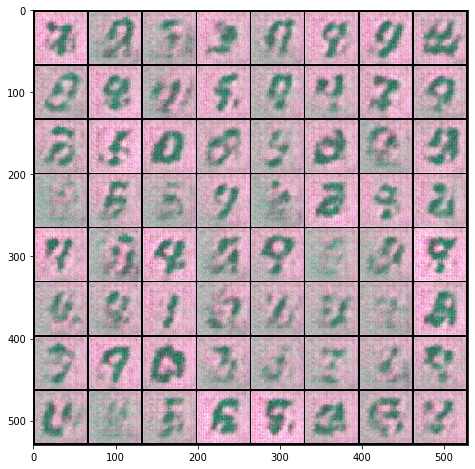

[0/5][650/700]	Loss_D: 0.4444	Loss_G: 1.3490	D(x): 0.7129	D(G(z)): 0.0730 / 0.2827
[1/5][0/700]	Loss_D: 0.8724	Loss_G: 0.2840	D(x): 0.4772	D(G(z)): 0.0221 / 0.7635
[1/5][50/700]	Loss_D: 0.5072	Loss_G: 0.8762	D(x): 0.7353	D(G(z)): 0.1562 / 0.4380
[1/5][100/700]	Loss_D: 0.2942	Loss_G: 2.2359	D(x): 0.8651	D(G(z)): 0.1320 / 0.1215
[1/5][150/700]	Loss_D: 0.3137	Loss_G: 1.8798	D(x): 0.8446	D(G(z)): 0.1280 / 0.1706
[1/5][200/700]	Loss_D: 0.5712	Loss_G: 1.2303	D(x): 0.6315	D(G(z)): 0.0728 / 0.3208
[1/5][250/700]	Loss_D: 0.8465	Loss_G: 4.8095	D(x): 0.9587	D(G(z)): 0.5277 / 0.0096
[1/5][300/700]	Loss_D: 0.4167	Loss_G: 2.6602	D(x): 0.8359	D(G(z)): 0.2022 / 0.0780
[1/5][350/700]	Loss_D: 0.7315	Loss_G: 2.6917	D(x): 0.8797	D(G(z)): 0.4234 / 0.0821
[1/5][400/700]	Loss_D: 1.0292	Loss_G: 4.5212	D(x): 0.9774	D(G(z)): 0.5930 / 0.0208
[1/5][450/700]	Loss_D: 0.5385	Loss_G: 1.6508	D(x): 0.6707	D(G(z)): 0.1095 / 0.2132
[1/5][500/700]	Loss_D: 0.4366	Loss_G: 1.8359	D(x): 0.7168	D(G(z)): 0.0836 / 0.1766


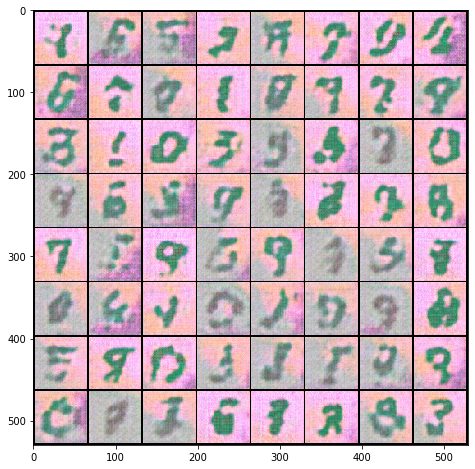

[1/5][550/700]	Loss_D: 0.4496	Loss_G: 2.6962	D(x): 0.9318	D(G(z)): 0.3039 / 0.0770
[1/5][600/700]	Loss_D: 0.5996	Loss_G: 1.5285	D(x): 0.7436	D(G(z)): 0.2445 / 0.2389
[1/5][650/700]	Loss_D: 1.0485	Loss_G: 0.9660	D(x): 0.3819	D(G(z)): 0.0199 / 0.4158
[2/5][0/700]	Loss_D: 0.5601	Loss_G: 1.8716	D(x): 0.6240	D(G(z)): 0.0456 / 0.1741
[2/5][50/700]	Loss_D: 0.4586	Loss_G: 1.5402	D(x): 0.7428	D(G(z)): 0.1314 / 0.2395
[2/5][100/700]	Loss_D: 0.3330	Loss_G: 2.0623	D(x): 0.8403	D(G(z)): 0.1390 / 0.1453
[2/5][150/700]	Loss_D: 1.1594	Loss_G: 0.8883	D(x): 0.3607	D(G(z)): 0.0255 / 0.4583
[2/5][200/700]	Loss_D: 2.1479	Loss_G: 1.7181	D(x): 0.9618	D(G(z)): 0.8533 / 0.2134
[2/5][250/700]	Loss_D: 0.8396	Loss_G: 1.1868	D(x): 0.4869	D(G(z)): 0.0538 / 0.3357


KeyboardInterrupt: ignored

In [20]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(EPOCHS):
  netG.train()
  netD.train()
  for i, x in enumerate(trainloader, 0):
    x = x.to(device).float()
   
    # real label
    b_size = x.size(0)
    label = torch.full((b_size,), real_label, device=device)

    errD_real, D_x = train_d_net_with_real(x, label)

    # Generate batch of latent vectors
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)

    errD, D_G_z1 = train_d_net_with_fake(label, fake, errD_real)

    errG, D_G_z2 = train_g_net(x, label, fake)


    # print stats
    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 600 == 0) or ((epoch == EPOCHS-1) and (i == len(trainloader)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        image_fake = vutils.make_grid(fake, padding=2, normalize=True)
        
        fig = plt.figure(figsize=(8,8))
        plt.imshow(np.transpose(image_fake, (1,2,0)), animated=True)
        plt.show()
        img_list.append(image_fake)

    iters += 1
  

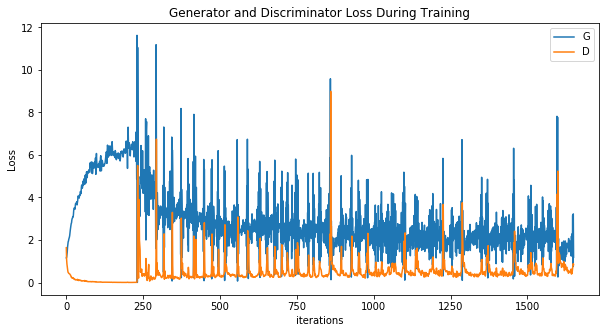

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

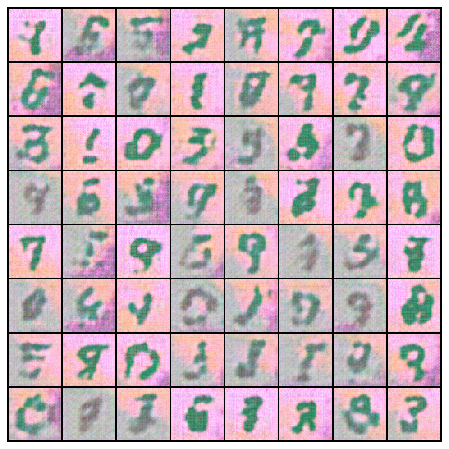

In [22]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

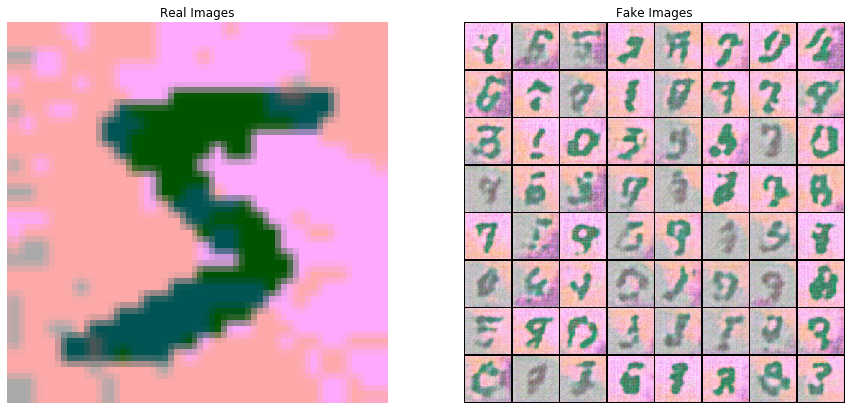

In [23]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()